<a href="https://colab.research.google.com/github/ParneUshaChandanaReddy/TextClassifier_News/blob/main/TextClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# New Section

In [2]:

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
downloaded = drive.CreateFile({'id':'1mhyBONtfkLT8OkOt85CfTpiMDU8nolg3'}) # replace the id with id of file you want to access
downloaded.GetContentFile('News_Category_Dataset.json') 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# get nltk data
nltk.download('stopwords')
nltk.download('wordnet')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [8]:
# load dataset
news_df = pd.read_json('News_Category_Dataset.json', lines=True)
news_df.head()



,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [9]:
print(news_df.category.unique())

['CRIME' 'ENTERTAINMENT' 'WORLD NEWS' 'IMPACT' 'POLITICS' 'WEIRD NEWS'
 'BLACK VOICES' 'WOMEN' 'COMEDY' 'QUEER VOICES' 'SPORTS' 'BUSINESS'
 'TRAVEL' 'MEDIA' 'TECH' 'RELIGION' 'SCIENCE' 'LATINO VOICES' 'EDUCATION'
 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS' 'WORLDPOST' 'FIFTY' 'ARTS'
 'WELLNESS' 'PARENTING' 'HOME & LIVING' 'STYLE & BEAUTY' 'DIVORCE'
 'WEDDINGS' 'FOOD & DRINK' 'MONEY' 'ENVIRONMENT' 'CULTURE & ARTS']


In [ ]:
df['category']=df['category'].replace({
"HEALTHY LIVING": "WELLNESS",
"QUEER VOICES": "GROUPS VOICES",
"BUSINESS": "BUSINESS & FINANCES",
"PARENTS": "PARENTING",
"BLACK VOICES": "GROUPS VOICES",
"THE WORLDPOST": "WORLD NEWS",
"STYLE": "STYLE & BEAUTY",
"GREEN": "ENVIRONMENT",
"TASTE": "FOOD & DRINK",
"WORLDPOST": "WORLD NEWS",
"SCIENCE": "SCIENCE & TECH",
"TECH": "SCIENCE & TECH",
"MONEY": "BUSINESS & FINANCES",
"ARTS": "ARTS & CULTURE",
"COLLEGE": "EDUCATION",
"LATINO VOICES": "GROUPS VOICES",
"CULTURE & ARTS": "ARTS & CULTURE",
"FIFTY": "MISCELLANEOUS",
"GOOD NEWS": "MISCELLANEOUS"
})

In [11]:
# combining some raw data categories that are very close
news_df.category = news_df.category.map(
    lambda x: "WORLD" if x == "WORLDPOST" or x == "THE WORLDPOST" or x == 'WORLD NEWS' else x)
news_df.category = news_df.category.map(
    lambda y: "ARTS & CULTURE" if y == "ARTS" or y == "ARTS & CULTURE" else y)
news_df.category = news_df.category.map(
    lambda z: "EDUCATION" if z == "EDUCATION" or z == "COLLEGE" else z)
news_df.category = news_df.category.map(
    lambda d: "HEALTH" if d == "HEALTHY LIVING" else d)

# removing rows with description size less than 20
mask = news_df['short_description'].str.len() > 20
news_df = news_df.loc[mask]
# combines headline and short_description for the input
news_df['text'] = news_df.headline+" "+news_df.short_description
# replace empty values with NaN
news_df = news_df.replace("", np.NaN)
# drop rows with value as NaN
news_df.dropna(axis=0, inplace=True)

In [12]:
# removing symbols,digits,stopwords from text and lemmatizing each words in the text.
import re
symbols_dt = re.compile('[/(){}\[\]\|@,;]')
symbols_dt2 = re.compile('[^0-9a-z +_]')
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = text.lower()
    text = symbols_dt.sub(' ', text)  # remove symbols in text data
    text = symbols_dt2.sub('', text)
    # delete stopwords from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    text = ' '.join([lemmatizer.lemmatize(w) for w in text.split()])
    return text


news_df['text'] = news_df['text'].apply(clean_text)
news_df['text'] = news_df['text'].str.replace('\d+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: The default value of regex will change from True to False in a future version.


In [13]:

# here v represents each category as an integer in the category_id column.
from io import StringIO
col = ['category', 'text']
# news_df = news_df.reindex(columns=col)


news_df = news_df[col]
news_df = news_df[pd.notnull(news_df['text'])]

news_df.columns = ['category', 'text']
news_df['category_id'] = news_df['category'].factorize()[0]
category_id_df = news_df[['category', 'category_id']
                         ].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)
# print(category_to_id)
news_df.head


<bound method NDFrame.head of              category                                               text  \
0               CRIME   mass shooting texas last week  tv left husban...   
1       ENTERTAINMENT  smith join diplo nicky jam  world cup official...   
2       ENTERTAINMENT  hugh grant marries first time age  actor longt...   
3       ENTERTAINMENT  jim carrey blast castrato adam schiff democrat...   
4       ENTERTAINMENT  julianna margulies us donald trump poop bag pi...   
...               ...                                                ...   
200843           TECH  good game possible dont think people play zyng...   
200844           TECH  google+ open teen safeguard part teen experien...   
200845           TECH  web war web war threaten rage considerable tim...   
200847           TECH  watch top  youtube video week youre looking se...   
200848           TECH  rim ceo thorsten heins significant plan blackb...   

        category_id  
0                 0  
1            

In [14]:
# set category column as an index
news_df = news_df.set_index("category")
news_df

,text,category_id
category,,
CRIME,mass shooting texas last week tv left husban...,0
ENTERTAINMENT,smith join diplo nicky jam world cup official...,1
ENTERTAINMENT,hugh grant marries first time age actor longt...,1
ENTERTAINMENT,jim carrey blast castrato adam schiff democrat...,1
ENTERTAINMENT,julianna margulies us donald trump poop bag pi...,1
...,...,...
TECH,good game possible dont think people play zyng...,14
TECH,google+ open teen safeguard part teen experien...,14
TECH,web war web war threaten rage considerable tim...,14


In [15]:
# drop some categories
news_df = news_df.drop(['IMPACT', 'QUEER VOICES', 'LATINO VOICES', 'BLACK VOICES', 'FIFTY',
                        'WEIRD NEWS', 'ENTERTAINMENT', 'GREEN', 'GOOD NEWS', 'COMEDY', 'PARENTS', 'WOMEN',
                        'POLITICS', 'MEDIA'], axis=0)
news_df = news_df.replace("", np.NaN)
# drop rows with value as NaN
news_df.dropna(axis=0, inplace=True)

In [16]:
# reset the index,
news_df = news_df.reset_index("category")
news_df

,category,text,category_id
0,CRIME,mass shooting texas last week tv left husban...,0
1,WORLD,north korea still open talk trump cancel summi...,5
2,WORLD,thousand travel home ireland vote abortion acc...,5
3,CRIME,rachel dolezal face felony charge welfare frau...,0
4,CRIME,man face charge pulling knife stun gun muslim ...,0
...,...,...,...
79090,TECH,good game possible dont think people play zyng...,14
79091,TECH,google+ open teen safeguard part teen experien...,14
79092,TECH,web war web war threaten rage considerable tim...,14
79093,TECH,watch top youtube video week youre looking se...,14


In [17]:
category_id_df = news_df[['category', 'category_id']
                         ].sort_values('category_id')
category_to_id = dict(category_id_df.values)
print(category_to_id)

{'CRIME': 0, 'WORLD': 5, 'SPORTS': 10, 'BUSINESS': 11, 'TRAVEL': 12, 'TECH': 14, 'RELIGION': 15, 'SCIENCE': 17, 'EDUCATION': 18, 'ARTS & CULTURE': 20, 'STYLE': 21, 'TASTE': 23, 'HEALTH': 24, 'WELLNESS': 27, 'PARENTING': 28, 'HOME & LIVING': 29, 'STYLE & BEAUTY': 30, 'WEDDINGS': 31, 'FOOD & DRINK': 32, 'DIVORCE': 33, 'MONEY': 34, 'ENVIRONMENT': 35, 'CULTURE & ARTS': 36}


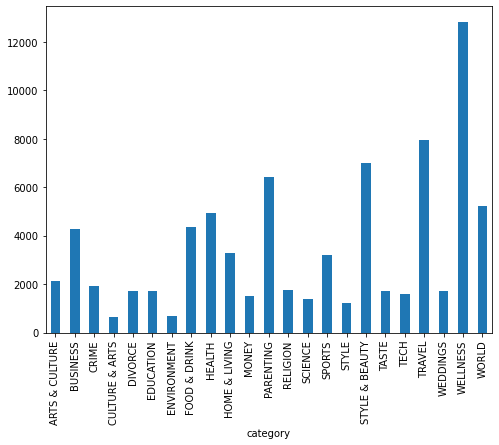

In [18]:
# ploting each category and corresponding no of samples - bar chart
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 6))
news_df.groupby('category').text.count().plot.bar(ylim=0)
plt.show()

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
d = news_df["text"].__iter__()
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        norm='l2', encoding='latin-1', ngram_range=(1, 2))
features = tfidf.fit_transform(d)
labels = news_df.category_id
features.shape

(79095, 45313)

In [20]:
# train the classifier
# Naive Bayes Classifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(news_df['text'],
                                                    news_df['category'], random_state=0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)
# print(clf)

In [21]:
print(clf.predict(count_vect.transform([
    "Climate change poses mental health risks to children and teens"
])))

['WELLNESS']


In [22]:
print(clf.predict(count_vect.transform([
    "Feeling upset because of travel"
])))

['TRAVEL']


In [24]:
print(clf.predict(count_vect.transform([
    "Joyful hockey playground"
])))

['WELLNESS']


In [25]:
print(clf.predict(count_vect.transform([

    "Champions League Final: Gary Lineker backs Liverpool to beat Tottenham in Madrid"

])))

['SPORTS']


In [26]:
# using multinomialNB
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    features, labels, news_df.index, test_size=0.33, random_state=0
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [27]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
print(metrics.classification_report(y_test, y_pred,
                                    target_names=news_df['category'].unique()))
print('accuracy %s' % accuracy_score(y_pred, y_test))

                precision    recall  f1-score   support

         CRIME       0.92      0.31      0.47       642
         WORLD       0.67      0.74      0.70      1641
        SPORTS       0.93      0.46      0.61      1077
      BUSINESS       0.61      0.28      0.38      1396
        TRAVEL       0.55      0.82      0.66      2588
          TECH       1.00      0.06      0.12       499
      RELIGION       0.95      0.08      0.14       540
       SCIENCE       1.00      0.03      0.06       435
     EDUCATION       0.93      0.05      0.09       557
ARTS & CULTURE       0.92      0.03      0.06       691
         STYLE       1.00      0.01      0.01       394
         TASTE       1.00      0.00      0.01       587
        HEALTH       0.92      0.04      0.08      1588
      WELLNESS       0.32      0.97      0.48      4326
     PARENTING       0.66      0.45      0.54      2094
 HOME & LIVING       0.97      0.38      0.54      1065
STYLE & BEAUTY       0.72      0.80      0.76  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
